# Training of BERT model for Fake News Detection (german)

**AFE2 project - Hochschule Luzern (HSLU)**


• Bianca Baumann

• Mejra Beso

• Ho-Yin Lam

• Robin Rinne

In [ ]:
!pip install transformers

In [ ]:
# Cloning GIT-Repo for FANG Covid Dataset
!apt-get install -y git
!git clone "https://github.com/justusmattern/fang-covid" "data"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
# Read FANG Covid Dataset .JSON Files and write them to .csv File
import json
import os
import csv
import codecs
import re
import string
import numpy as np

# get .json files in dir
json_directory = "data/articles"
csv_directory = "test.csv"
json_files = [f for f in os.listdir(json_directory) if f.endswith('.json')]

articles = []
index = 0

# change the label from 0, 1 to fake, real
for json_file in json_files:
  with open(os.path.join(json_directory, json_file), 'r') as file:
    data = json.load(file)
    label_value = 0
    if data["label"] == "fake":
      label_value = 0
    elif data["label"] == "real":
      label_value = 1

    # data cleaning
    cleaned_article = re.sub(r'http\S+', '', data["article"])
    cleaned_article = re.sub(r'@\S', '', cleaned_article)
    cleaned_article = re.sub(r' +', ' ', cleaned_article)
    cleaned_article = cleaned_article.strip()
    cleaned_article = re.sub(r'\n', '', cleaned_article)
    cleaned_article = re.sub(r"[\"\'<>\`\´\*\+\-;#]", '', cleaned_article)

    article = {
      "id": index,
      "article": cleaned_article,
      "label": label_value,
      "categorie": "covid"
    }
    articles.append(article)
    index += 1

# write the articles to the .csv file
with open(csv_directory, 'w+', newline='', encoding='utf-8-sig') as csvfile:
    fieldnames = ["id", "article", "label", "categorie"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for article in articles:
      if article["id"] % 1 == 0: # Modulo to increase/decrease number of articles used for training
        writer.writerow(article)

print(f'Die Daten wurden in "{csv_directory}" gespeichert.')

Die Daten wurden in "test.csv" gespeichert.


In [ ]:
import requests

# dropbox link to download the Fake News Dataset German .csv
dropbox_url = "https://www.dropbox.com/scl/fi/udq562z92zity0u51sl97/news.csv?rlkey=c0wd3ahc70s6pbf7w2yli2cq3&dl=1"

file_name = "news.csv"

# download the file
r = requests.get(dropbox_url)
with open(file_name, "wb") as file:
    file.write(r.content)

print(f"File {file_name} was downloaded successfully.")

Datei news.csv wurde erfolgreich heruntergeladen.


In [ ]:
# Read Fake News Dataset German and write them to .csv File
import json
import os
import csv
import codecs
import re
import string
import pandas as pd

articles = []
csv_directory = "test.csv"

# read dataset .csv file
with open('news.csv', 'r') as file:
  csv_reader = csv.reader(file)

  header = next(csv_reader)
  print(header)

  for index, row in enumerate(csv_reader, 1):
    id_value = index
    article = row[3]
    label = row[7]
    categorie = row[4]

    # data cleaning
    cleaned_article = re.sub(r'http\S+', '', article)
    cleaned_article = re.sub(r'@\S', '', cleaned_article)
    cleaned_article = re.sub(r' +', ' ', cleaned_article)
    cleaned_article = cleaned_article.strip()
    cleaned_article = re.sub(r'\n', '', cleaned_article)
    cleaned_article = re.sub(r"[\"\'<>\`\´\*\+\-;#]", '', cleaned_article)

    label = pd.to_numeric(label, errors='coerce')
    label = 1 - label

    article = {
        "id": id_value,
        "article": cleaned_article,
        "label": label,
        "categorie": categorie.lower()
    }

    articles.append(article)

# write articles to .csv file
with open(csv_directory, 'a', newline='', encoding='utf-8-sig') as csvfile:
    fieldnames = ["id", "article", "label", "categorie"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    for article in articles:
      if article["id"] % 1 == 0: # Modulo to increase/decrease number of articles used for training
        writer.writerow(article)

print(f'Die Daten wurden in "{csv_directory}" gespeichert.')

['id', 'url', 'Titel', 'Body', 'Kategorie', 'Datum', 'Quelle', 'Fake', 'Art']
Die Daten wurden in "test.csv" gespeichert.


In [ ]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv("test.csv")
df.head()

,id,article,label,categorie
0,0,Während gegenwärtig fast ausschließlich der „K...,0,covid
1,1,"Boxen, WM: Anthony Joshua bleibt vierfacher We...",1,covid
2,2,Quarantäne kann für ältere Menschen schlimme F...,1,covid
3,3,"Statt 2,5 Millionen Muslimen dürfen dieses Jah...",1,covid
4,4,Strafzölle auf Wein gegen Strafzölle auf Humme...,1,covid


In [ ]:
# Split Data into test and train and validation
train_text, temp_text, train_labels, temp_labels = train_test_split(df['article'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.4,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
print("FOR DATASET\n")
print('Average word length of article in train set is {0:.0f}.'.format(np.mean(df['article'].apply(lambda x: len(x.split())))))
print('Max word length of article in train set is {0:.0f}.'.format(np.max(df['article'].apply(lambda x: len(x.split())))))
print('Average character length of article in train set is {0:.0f}.'.format(np.mean(df['article'].apply(lambda x: len(x)))))
print('Label Distribution in train set is \n{}.'.format(df['label'].value_counts()))
print('Categorie distribution in train set is \n{}.'.format(df['categorie'].value_counts()))

FOR DATASET

Average word length of article in train set is 509.
Max word length of article in train set is 44522.
Average character length of article in train set is 3692.
Label Distribution in train set is 
1    87297
0    17813
Name: label, dtype: int64.
Categorie distribution in train set is 
covid                      41242
weltnachrichten             9626
unternehmensnachrichten     7968
business                    6628
leben                       6436
inlandsnachrichten          5461
hightech                    4842
medien                      4683
wirtschaftsnachrichten      4497
top-nachrichten             2884
politik                     1836
marktnachrichten            1669
wirtschaft                  1618
international                731
sport                        660
österreich                   522
panorama                     507
chronik                      483
leute                        422
adhoc                        392
kultur                       200
wissensch

In [ ]:
df.groupby('categorie')['label'].value_counts()

categorie                label
adhoc                    1          392
arktnachrichten          1            3
business                 1         6628
chronik                  0          483
covid                    1        28056
                         0        13186
eltnachrichten           1          128
gesundheit               0           10
hightech                 1         4842
inlandsnachrichten       1         5461
international            1          579
                         0          152
irtschaftsnachrichten    1           41
kultur                   1          193
                         0            7
leben                    1         6436
leute                    1          337
                         0           85
marktnachrichten         1         1669
medien                   1         4598
                         0           85
nlandsnachrichten        1          116
nternehmensnachrichten   1           39
op-nachrichten           1            1
panorama 

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-german-cased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-german-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


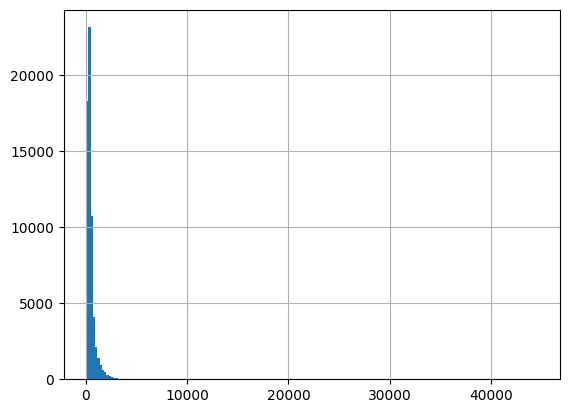

In [ ]:
# tokenization
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 200)

max_seq_len = 50

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Convert Integer Sequences to Tensors

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#Create DataLoaders

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
#Freeze BERT Parameters

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
# Define model architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):

      # pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Find Class Weights

from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight(class_weight = "balanced", classes = np.unique(train_labels), y= train_labels)

print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 5

[2.95031811 0.60202757]


In [ ]:
# Fine-Tune BERT

# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)
        # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
#Start Model Training

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of  1,971.
  Batch   100  of  1,971.
  Batch   150  of  1,971.
  Batch   200  of  1,971.
  Batch   250  of  1,971.
  Batch   300  of  1,971.
  Batch   350  of  1,971.
  Batch   400  of  1,971.
  Batch   450  of  1,971.
  Batch   500  of  1,971.
  Batch   550  of  1,971.
  Batch   600  of  1,971.
  Batch   650  of  1,971.
  Batch   700  of  1,971.
  Batch   750  of  1,971.
  Batch   800  of  1,971.
  Batch   850  of  1,971.
  Batch   900  of  1,971.
  Batch   950  of  1,971.
  Batch 1,000  of  1,971.
  Batch 1,050  of  1,971.
  Batch 1,100  of  1,971.
  Batch 1,150  of  1,971.
  Batch 1,200  of  1,971.
  Batch 1,250  of  1,971.
  Batch 1,300  of  1,971.
  Batch 1,350  of  1,971.
  Batch 1,400  of  1,971.
  Batch 1,450  of  1,971.
  Batch 1,500  of  1,971.
  Batch 1,550  of  1,971.
  Batch 1,600  of  1,971.
  Batch 1,650  of  1,971.
  Batch 1,700  of  1,971.
  Batch 1,750  of  1,971.
  Batch 1,800  of  1,971.
  Batch 1,850  of  1,971.
  Batch 1,900  of  1,971

# Get Predictions for Test Data

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):

      # pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-german-cased')

# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('saved_weights.pt'))

<All keys matched successfully>

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# reducing batch size for getting predictions because of RAM overload
def predict_in_batches(model, dataloader):
  batch_preds = []
  with torch.no_grad():
    for batch in dataloader:
      seq, mask = batch
      preds = model(seq.to(device), mask.to(device))
      batch_preds.append(preds.detach().cpu().numpy())
      torch.cuda.empty_cache()
  return np.concatenate(batch_preds, axis=0)

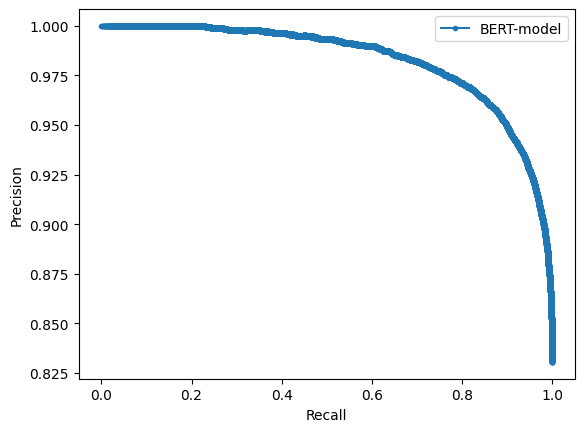


Matthews Corr Coef: 0.5668464569740899
Precision: 0.9682625430481464
Recall: 0.8212956068503351
f-1 score: 0.8453601187787645
              precision    recall  f1-score   support

           0       0.50      0.87      0.63      3563
           1       0.97      0.82      0.89     17459

    accuracy                           0.83     21022
   macro avg       0.73      0.84      0.76     21022
weighted avg       0.89      0.83      0.85     21022



In [ ]:
#Get Predictions for Test Data

# get predictions for test data
test_dataloader = DataLoader(TensorDataset(test_seq, test_mask), batch_size=16)
preds = predict_in_batches(test_model, test_dataloader)

# model's performance
precision_, recall_, proba = precision_recall_curve(test_y, preds[:, -1])
preds = np.argmax(preds, axis = 1)

# plot precision-recall curve
plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

mcc = matthews_corrcoef(test_y, preds)
tn, fp, fn, tp = confusion_matrix(test_y, preds).ravel()
precision = precision_score(test_y, preds)
recall = recall_score(test_y, preds)
f1 = f1_score(test_y, preds, average='weighted')

print("")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)

print(classification_report(test_y, preds))

# Using the trained model to identify fake or real news

Use the pretrained model (dropbox download - no training needed) to test for Fake/Real probablity.

In [ ]:
import requests

# dropbox link to the pretrained model
dropbox_url = "https://www.dropbox.com/scl/fi/n6bg2tfh2erfej8wudtdj/bert_model_state.bin?rlkey=un6av06g650mwo99p9rvlegkm&dl=1"

file_name = "bert_model_state.bin"

# download the file
r = requests.get(dropbox_url)
with open(file_name, "wb") as file:
    file.write(r.content)

print(f"File {file_name} was downloaded successfully.")

Datei bert_model_state.bin wurde erfolgreich heruntergeladen.


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-german-cased')

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
model = model.to(device)
model.load_state_dict(torch.load('saved_weights.pt'))

# loading the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

In [ ]:
def classify_text(text):

    model.to(device)

    # tokenizing the text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=32, return_tensors="pt")

    # extract necessary inputs
    sent_id = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)

    # prediction with the trained model
    with torch.no_grad():
        outputs = model(sent_id=sent_id, mask=mask)

    # calculate probabilities for each class
    probabilities = torch.nn.functional.softmax(outputs, dim=-1)

    # probability of “Fake” and “Real”
    fake_prob = probabilities[:, 0].item()  # Annahme: Klasse 0 ist "Fake"
    real_prob = probabilities[:, 1].item()  # Annahme: Klasse 1 ist "Real"

    return {"fake_prob": fake_prob, "real_prob": real_prob}

In [ ]:
# Text to test for Fake-News
text= "Fake-News Test Text"

# Classification of the text with probability for each class
result = classify_text(text)
print(f"Fake Probability: {result['fake_prob']}")
print(f"Real Probability: {result['real_prob']}")

Fake-Wahrscheinlichkeit: 0.48768287897109985
Real-Wahrscheinlichkeit: 0.5123171210289001
